# Breakfast Restaurant Locations
The aim of this notebook is to determine which communities in Calgary are best suited for a newly opening independent breakfast restaurant. According to [multiple](https://www.forbes.com/sites/alexandratalty/2016/10/17/millennials-spend-44-percent-of-food-dollars-on-eating-out-says-food-institute/#5161621a3ff6) [articles](https://www.huffingtonpost.com/olivia-deng/brunchnomics-what-brunch-_b_14298840.html), as well as my own anecdotal evidence (from visiting approximately 70 unique, independent breakfast restaurants in 2018), the biggest age demographic for dining at independent breakfast restaurants is 18-35 years old (commonly referred to as "millennials"). The goal is to find areas with lots of potentially breakfast-hungry millennials, and a below-average number of breakfast restaurants.

(Note: this notebook is very much in a sequential, almost stream-of consciousness order. The order you see the cells in is roughly in the order I made them.)

## Acquisition and Processing

In [133]:
# Import libs
import math
import pandas as pd
import numpy as np
import plotly.offline as py # TODO switch to online mode to generate iframe-ready graphs on plot.ly
import plotly.graph_objs as go
import folium
import json, requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's start by gathering the 2016 census data, which is already grouped into communities. We need to use data from 2016, as this was the most recent year that demographic information was collected. The next census with demographics will be later this year (2019). Additionally, since all Open Calgary data is available via the SODA API, we can select columns in our request (a bit like SQL). 

In [4]:
request_fields = ['CLASS', 'CLASS_CODE', 'COMM_CODE', 'NAME', 'COMM_STRUCTURE', 'RES_CNT', 'DWELL_CNT', 'EMPLYD_CNT',
                  'MF_0_4', 'MF_5_14', 'MF_15_19', 'MF_20_24', 'MF_25_34', 'MF_35_44', 'MF_45_54', 'MF_55_64', 'MF_65_74', 'MF_75']
url = 'https://data.calgary.ca/resource/mndt-3a4i.csv?$select=' + ','.join(request_fields) # Census 2016
print(url)
census = pd.read_csv(url)
census.head()

https://data.calgary.ca/resource/mndt-3a4i.csv?$select=CLASS,CLASS_CODE,COMM_CODE,NAME,COMM_STRUCTURE,RES_CNT,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_5_14,MF_15_19,MF_20_24,MF_25_34,MF_35_44,MF_45_54,MF_55_64,MF_65_74,MF_75


,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,MF_35_44,MF_45_54,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,0,0,0,0,0,0,MANCHESTER INDUSTRIAL,0
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,4,4,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15
2,Major Park,3,COP,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,CANADA OLYMPIC PARK,0
3,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,115,30,20,0,12,0,FOOTHILLS,304
4,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,31,47,65,9,37,23,SHEPARD INDUSTRIAL,273


We also want geodata on every community. `calgary_geo` is a geojson file defining the boundries of all communities ([downloaded from here](https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6)). `comm_locs` is the centroids of all communities, from [this dataset](https://data.calgary.ca/Base-Maps/Community-Points/j9ps-fyst).

In [7]:
calgary_geo = 'data/Community Boundaries.geojson' # This should be identical to the multipolygon field included in the census, but it saves me some hassle of transforming data for Folium's picky needs.
request_fields = ['COMM_CODE', 'latitude', 'longitude']
url = 'https://data.calgary.ca/resource/kzbm-mn66.csv?$select=' + ','.join(request_fields) # 
comm_locs = pd.read_csv(url)
comm_locs.head()

,COMM_CODE,latitude,longitude
0,EYA,51.012993,-114.073623
1,ESH,50.951252,-113.950957
2,PEN,51.045863,-113.947522
3,SCE,51.112684,-114.217279
4,RAN,51.119163,-114.183601


In [14]:
census = census.merge(comm_locs, on='COMM_CODE')
census.head()

,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,MF_35_44,MF_45_54,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT,latitude,longitude
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,0,0,0,0,0,0,MANCHESTER INDUSTRIAL,0,51.013263,-114.057269
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,4,4,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15,50.984817,-114.037243
2,Major Park,3,COP,OTHER,0,0,0,0,0,0,0,0,0,0,0,0,CANADA OLYMPIC PARK,0,51.080787,-114.217426
3,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,115,30,20,0,12,0,FOOTHILLS,304,50.994166,-113.981982
4,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,31,47,65,9,37,23,SHEPARD INDUSTRIAL,273,50.961480,-113.992775
5,Major Park,3,FPK,PARKS,0,0,0,0,0,0,0,0,0,0,0,0,FISH CREEK PARK,0,50.909602,-114.026521
6,Residual Sub Area,4,12B,UNDEVELOPED,7,9,1,0,0,1,5,0,2,3,2,3,12B,17,50.939231,-113.898687
7,Industrial,2,ST4,EMPLOYMENT,4,0,0,0,0,0,0,0,0,0,0,0,STONEY 4,0,51.176204,-114.002762
8,Industrial,2,ST1,EMPLOYMENT,4,0,0,0,0,0,0,0,0,0,0,0,STONEY 1,0,51.161184,-114.024717
9,Industrial,2,NAW,EMPLOYMENT,3,0,0,0,0,0,0,0,0,0,0,0,NORTH AIRWAYS,0,51.087140,-114.010880


Let's quickly generate a map of Calgary to verify that our geojson matches our dataframe. Unfortunately, complex maps do not work natively in jupyterlab, so I have to use the workaround [here](https://github.com/python-visualization/folium/issues/812).

In [15]:
def embed_map(m, name):
    from IPython.display import IFrame

    m.save(name+'.html')
    return IFrame(name+'.html', width='100%', height='750px')

In [18]:
map_communities = folium.Map(location=[51.0486, -114.0708], zoom_start=11)

folium.Choropleth(
    geo_data = calgary_geo,
    data = census,
    columns = ['NAME', 'RES_CNT'],
    key_on = 'feature.properties.name',
    fill_color='YlGn'
).add_to(map_communities)
map_communities.save('comm.html')
embed_map(map_communities, 'comms')

The black communities are expected, as they have been created between 2016 and 2018, and therefore have no census data from 2016.

Next, let's get all the breakfast restaurants within the bounding box of each community. We'll use a radius of 2km, so that larger communities are properly covered. We'll get duplicates with the smaller communities, but we'll deal with that later.

In [31]:
# Import Foursquare keys from a json file outside this repo
from pathlib import Path
with open(str(Path.home())+'/jupyter/foursquare.json') as f:
    client_id, client_secret = json.load(f)

In [44]:
all_venues = []

for index, row in census.iterrows():
    params = dict(
        client_id=client_id, 
        client_secret=client_secret,
        v='20180323',
        limit=50,
        ll=str(row['latitude'])+','+str(row['longitude']),
        query='breakfast'
    )
    res = requests.get(url='https://api.foursquare.com/v2/venues/explore', params=params)
    print( row['NAME'])
    venues = json.loads(res.text)['response']['groups'][0]['items']
    for venue in venues:
        venue_row = [
            row['NAME'],
            row['COMM_CODE'],
            venue['venue']['name'],
            venue['venue']['id'],
            venue['venue']['location']['lat'],
            venue['venue']['location']['lng'],
            venue['venue']['categories']
        ]
        print(venue['venue']['name'])
        all_venues.append(venue_row)


venue_df = pd.DataFrame(all_venues, columns = ['Community Name', 'Community Code', 'Venue Name', 'Venue ID', 'Lat', 'Long', 'Categories'])

MANCHESTER INDUSTRIAL
Coco Brooks
Phil & Sebastian Coffee Roaster
Yann Haute Patisserie
Sidewalk Citizen Bakery
Rosso Coffee Roasters
The Glencoe Club
Bolero
Smuggler's Inn
The Keg Steakhouse + Bar
Starbucks
Purple Perk
Tango Bistro
Phil & Sebastian Coffee Roasters
La Boulangerie
Subway
Tim Hortons
Phil's Restaurant
Starbucks
Tim Hortons
A&W Canada
Fatburger
Starbucks
Red Lobster
Starbucks
Second Cup
Open Sesame
Tim Hortons
Cravings Market Restaurant
The Tea Factory
Subway
A&W Canada
Subway
Subway
7-Eleven
Ricky's
Green's
Dutch Cash & Carry
EAST FAIRVIEW INDUSTRIAL
Real Canadian Superstore
The Keg Steakhouse + Bar
Smuggler's Inn
Bolero
Phil & Sebastian Coffee Roaster
Starbucks
Fratello Analog Cafe
Jugo Juice
Tango Bistro
A&W Canada
Fatburger
Sidewalk Citizen Bakery
Cobs Bread
Starbucks
Cheesecake Cafe
Starbucks
A&W Canada
Tim Hortons
Starbucks
Phil's Restaurant
Starbucks
Denny's
Tom's House of Pizza
Cravings Market Restaurant
Tim Hortons
Starbucks
Open Sesame
Red Lobster
Tim Hortons
Su

In [45]:
venue_df.head()

,Community Name,Community Code,Venue Name,Venue ID,Lat,Long,Categories
0,MANCHESTER INDUSTRIAL,MNI,Coco Brooks,4be5a74abcef2d7fef1604e5,51.016488,-114.049436,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
1,MANCHESTER INDUSTRIAL,MNI,Phil & Sebastian Coffee Roaster,4ca4d97f7f84224b96e5d058,51.000426,-114.073290,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
2,MANCHESTER INDUSTRIAL,MNI,Yann Haute Patisserie,4b4a2bbbf964a5203c7d26e3,51.032246,-114.070671,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
3,MANCHESTER INDUSTRIAL,MNI,Sidewalk Citizen Bakery,4daf1e3f6a23e6c93498b0f8,51.005044,-114.067083,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
4,MANCHESTER INDUSTRIAL,MNI,Rosso Coffee Roasters,4b118d01f964a520187f23e3,51.031775,-114.043542,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...


Let's save this raw data as a csv in case we need it later...

In [47]:
venue_df.to_csv('venues_raw.csv')

Now we can start filtering out venues that aren't really similar to our future breakfast resturant, such as fast food chains. The first thing is to get rid of major chains based on how many locations are in Calgary.

In [55]:
venue_df.shape # How many venues did we grab, anyways?

(13997, 7)

In [54]:
venue_df['Venue Name'].value_counts()

Tim Hortons                          2056
Starbucks                            1493
Subway                               1143
7-Eleven                              680
A&W Canada                            635
McDonald's                            465
Booster Juice                         412
Second Cup                            340
Denny's                               223
Real Canadian Superstore              212
Jugo Juice                            132
Burger King                           118
Good Earth Cafe                       116
Cobs Bread                            103
Wendy's                                97
Tim Hortons / Esso                     89
Milestones                             88
Fatburger                              87
Waves Coffee House                     79
Phil & Sebastian Coffee Roasters       79
DAVIDsTEA                              65
Rosso Coffee Roasters                  64
A&W                                    61
Tim Hortons / Wendy's             

Looks like 50 locations is when we start transitioning from fast food (A&W, Tim Hortons) to more "sit down" places like Cora's. Let's create and apply a blacklist of prolific chains.

In [70]:
blacklist = venue_df['Venue Name'].value_counts()[venue_df['Venue Name'].value_counts() > 50].index.tolist()
venues_df_filtered = venue_df[~(venue_df['Venue Name'].isin(blacklist))]
venues_df_filtered

,Community Name,Community Code,Venue Name,Venue ID,Lat,Long,Categories
1,MANCHESTER INDUSTRIAL,MNI,Phil & Sebastian Coffee Roaster,4ca4d97f7f84224b96e5d058,51.000426,-114.073290,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
2,MANCHESTER INDUSTRIAL,MNI,Yann Haute Patisserie,4b4a2bbbf964a5203c7d26e3,51.032246,-114.070671,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
3,MANCHESTER INDUSTRIAL,MNI,Sidewalk Citizen Bakery,4daf1e3f6a23e6c93498b0f8,51.005044,-114.067083,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
5,MANCHESTER INDUSTRIAL,MNI,The Glencoe Club,4b69cf87f964a520a8b52be3,51.028676,-114.080626,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
6,MANCHESTER INDUSTRIAL,MNI,Bolero,4bd7626935aad13a8fc58ef3,50.992367,-114.070897,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
7,MANCHESTER INDUSTRIAL,MNI,Smuggler's Inn,4b0586e7f964a5202f7422e3,50.992029,-114.070742,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
8,MANCHESTER INDUSTRIAL,MNI,The Keg Steakhouse + Bar,4b0586e7f964a520e07322e3,50.990542,-114.070953,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
10,MANCHESTER INDUSTRIAL,MNI,Purple Perk,4b0336a9f964a520954d22e3,51.032799,-114.071519,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
11,MANCHESTER INDUSTRIAL,MNI,Tango Bistro,4ba56b9cf964a5205e0539e3,50.992173,-114.070919,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
13,MANCHESTER INDUSTRIAL,MNI,La Boulangerie,4f4d2b7ee4b081be1cf50c58,51.030881,-114.071669,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...


Now we've got a decent lineup of breakfasty-sounding places! Ideally I'd get the hours for each location, but that would take almost 10 days with my personal account. We'll just have to trust Foursquare's judgement that these venues are vaugely breakfast resturants. 

I'd like to remove any duplicates from our list of venues. However, this will also require reassigning community codes, otherwise we risk biasing towards the top of the list. 

In [127]:
venues_df_filtered.to_csv('venues_no_chains.csv') # Another CSV save just in case

In [129]:
venues_df_filtered = venues_df_filtered.drop_duplicates(subset='Venue ID')
venues_df_filtered.shape

(367, 7)

In [138]:
for venue_index, venue_row in venues_df_filtered.iterrows(): # TODO see if there is a faster way to do this. Itterating over a DF *inside* a DF itteration is silly. Maybe a map() to get distance?
    closest_dist = 10000 # Distance to current closest community
    closest_index = -1 # DF index of the closest community
    for comm_index, comm_row in census.iterrows():
        dist = math.sqrt( # Euclidian distance
            (float(venue_row['Lat']) - float(comm_row['latitude']))**2 +
            (float(venue_row['Long']) - float(comm_row['longitude']))**2
        )
        if dist < closest_dist:
            closest_dist = dist
            closest_index = comm_index
    venues_df_filtered.at[venue_index, 'Community Name'] = census.at[closest_index, 'NAME']
    venues_df_filtered.at[venue_index, 'Community Code'] = census.at[closest_index, 'COMM_CODE']
venues_df_filtered

,Community Name,Community Code,Venue Name,Venue ID,Lat,Long,Categories
1,MEADOWLARK PARK,MEA,Phil & Sebastian Coffee Roaster,4ca4d97f7f84224b96e5d058,51.000426,-114.073290,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
2,MISSION,MIS,Yann Haute Patisserie,4b4a2bbbf964a5203c7d26e3,51.032246,-114.070671,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
3,MANCHESTER,MAN,Sidewalk Citizen Bakery,4daf1e3f6a23e6c93498b0f8,51.005044,-114.067083,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
5,UPPER MOUNT ROYAL,UMR,The Glencoe Club,4b69cf87f964a520a8b52be3,51.028676,-114.080626,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
6,FAIRVIEW INDUSTRIAL,FVI,Bolero,4bd7626935aad13a8fc58ef3,50.992367,-114.070897,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
7,FAIRVIEW INDUSTRIAL,FVI,Smuggler's Inn,4b0586e7f964a5202f7422e3,50.992029,-114.070742,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
8,FAIRVIEW INDUSTRIAL,FVI,The Keg Steakhouse + Bar,4b0586e7f964a520e07322e3,50.990542,-114.070953,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
10,CLIFF BUNGALOW,CLI,Purple Perk,4b0336a9f964a520954d22e3,51.032799,-114.071519,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
11,FAIRVIEW INDUSTRIAL,FVI,Tango Bistro,4ba56b9cf964a5205e0539e3,50.992173,-114.070919,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...
13,CLIFF BUNGALOW,CLI,La Boulangerie,4f4d2b7ee4b081be1cf50c58,51.030881,-114.071669,[{'icon': {'prefix': 'https://ss3.4sqi.net/img...


Our next task is to take this venue list and reintegrate it with the census data so we can start doing some analytics. 

In [139]:
breakfast_per_comm = venues_df_filtered['Community Code'].value_counts().to_frame().reset_index()
breakfast_per_comm.columns = ['COMM_CODE', 'Breakfast']
breakfast_per_comm

,COMM_CODE,Breakfast
0,DNC,16
1,DNW,14
2,MCT,12
3,LMR,10
4,FVI,9
5,EAU,8
6,CLI,8
7,AUB,6
8,DNE,6
9,MEA,6


In [140]:
breakfast_census = census.merge(breakfast_per_comm, on='COMM_CODE')
breakfast_census

,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,...,MF_45_54,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT,latitude,longitude,Breakfast
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,...,0,0,0,0,0,MANCHESTER INDUSTRIAL,0,51.013263,-114.057269,2
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,...,4,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15,50.984817,-114.037243,1
2,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,...,30,20,0,12,0,FOOTHILLS,304,50.994166,-113.981982,2
3,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,...,47,65,9,37,23,SHEPARD INDUSTRIAL,273,50.961480,-113.992775,1
4,Industrial,2,ST4,EMPLOYMENT,4,0,0,0,0,0,...,0,0,0,0,0,STONEY 4,0,51.176204,-114.002762,1
5,Industrial,2,NAW,EMPLOYMENT,3,0,0,0,0,0,...,0,0,0,0,0,NORTH AIRWAYS,0,51.087140,-114.010880,6
6,Industrial,2,ST2,EMPLOYMENT,7,0,0,0,0,4,...,4,2,0,0,0,STONEY 2,15,51.143387,-114.017218,4
7,Industrial,2,GRI,EMPLOYMENT,5,1,0,3,6,8,...,8,13,0,11,85,GREENVIEW INDUSTRIAL PARK,145,51.088777,-114.047038,1
8,Residential,1,HAM,2000s,2474,3611,210,688,613,597,...,1566,1422,761,748,407,HAMPTONS,7706,51.145106,-114.146737,1
9,Industrial,2,RYV,EMPLOYMENT,0,0,0,0,0,0,...,0,0,0,0,0,ROYAL VISTA,0,51.149474,-114.204165,3


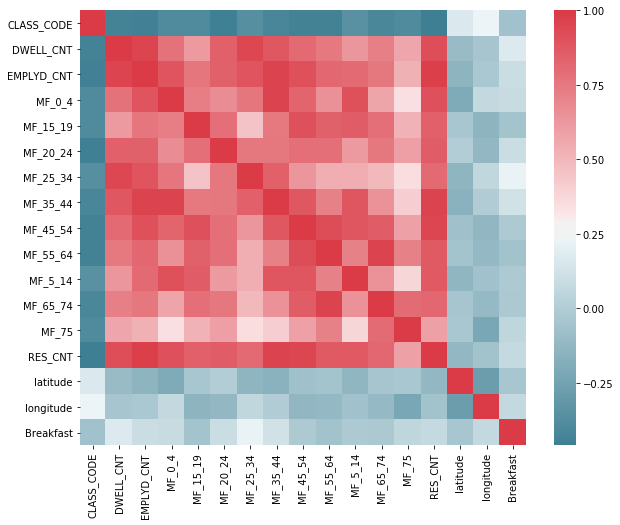

In [141]:
breakfast_corr = breakfast_census.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(breakfast_corr, mask=np.zeros_like(brekfast_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)

In [142]:
brekfast_corr['Breakfast'].sort_values()

MF_5_14      -0.219541
MF_15_19     -0.219344
MF_45_54     -0.167594
CLASS_CODE   -0.162177
MF_55_64     -0.157547
MF_65_74     -0.151949
MF_0_4       -0.139235
latitude     -0.125138
RES_CNT      -0.121087
MF_35_44     -0.092574
EMPLYD_CNT   -0.087024
MF_20_24     -0.061474
MF_75        -0.041933
longitude     0.010927
DWELL_CNT     0.018546
MF_25_34      0.049030
Breakfast     1.000000
Name: Breakfast, dtype: float64

Looks like the biggest correlations with breakfast restaurants are negative correlations with the number of kids and teens in the area. This matches my (purely annecdotal) experience, as I rarely see families with children in breakfast resturants. It seems like areas populated with middle-aged folk are not very keen on eating out for breakfast either.

Let's plot some age groups vs breakfast:

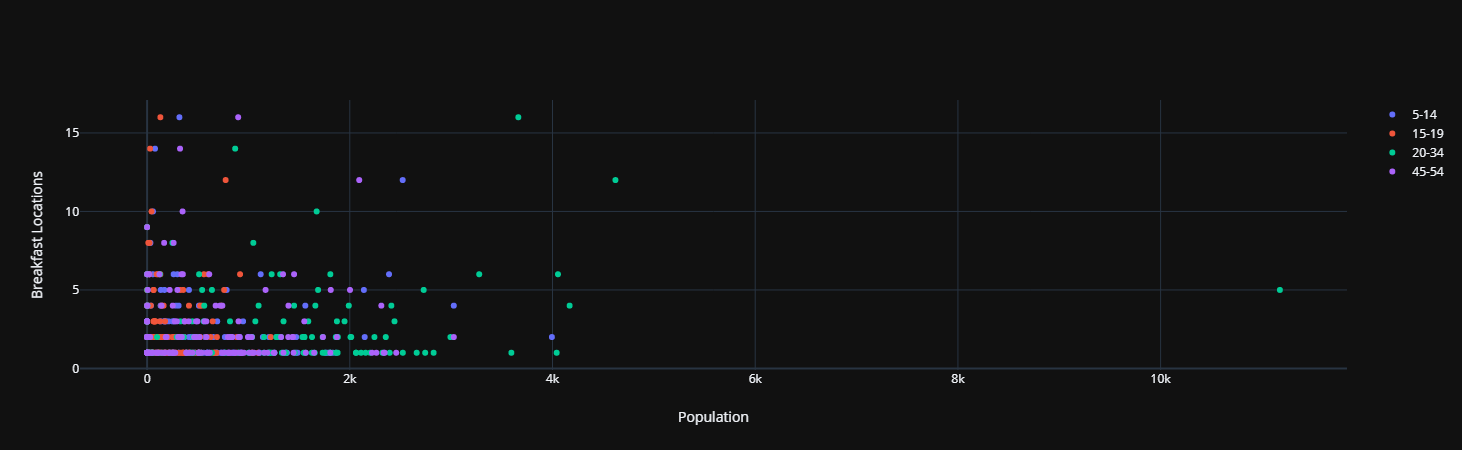

In [328]:
breakfast_kids_trace = go.Scatter(x = breakfast_census['MF_5_14'], y = breakfast_census['Breakfast'], name = '5-14', mode='markers')
breakfast_teen_trace = go.Scatter(x = breakfast_census['MF_15_19'], y = breakfast_census['Breakfast'], name = '15-19', mode='markers')
breakfast_miln_trace = go.Scatter(x = breakfast_census['MF_20_24']+breakfast_census['MF_25_34'], y = breakfast_census['Breakfast'], name = '20-34', mode='markers')
breakfast_25_34_trace = go.Scatter(x = breakfast_census['MF_25_34'], y = breakfast_census['Breakfast'], name = '25-34', mode='markers')
breakfast_midl_trace = go.Scatter(x = breakfast_census['MF_45_54'], y = breakfast_census['Breakfast'], name = '45-54', mode='markers')

breakfast_corr_layout = go.Layout(template='plotly_dark', xaxis={'title':'Population'}, yaxis={'title':'Breakfast Locations'})
py.plot({'data': [breakfast_kids_trace, breakfast_teen_trace, breakfast_miln_trace, breakfast_midl_trace], 'layout': breakfast_corr_layout}, filename = 'breakfast_by_age.html')
py.iplot({'data': [breakfast_kids_trace, breakfast_teen_trace, breakfast_miln_trace, breakfast_midl_trace], 'layout': breakfast_corr_layout}, filename = 'breakfast_by_age.html')

Remember, Plotly plots are interactive. You may want to try zooming in (click and drag) and isolating the different traces (clicking on the legend).

There indeed seems to be a general trend of areas with less minors and middle aged people having more breakfast restaurants. Interestingly, there does *not* seem to be any clear pattern between millenials and breakfast restaurants. Perhaps millenials commonly go for breakfast in communities outside their own?

Let's take a quick detour from age demographics, and instead on the physical distribution of these restaurants. That's easy enough with a choropleth:

In [153]:
map_breakfast = folium.Map(location=[51.0486, -114.0708], zoom_start=11)

folium.Choropleth(
    geo_data = calgary_geo,
    data = breakfast_census,
    columns = ['NAME', 'Breakfast'],
    key_on = 'feature.properties.name',
    fill_color='YlGn'
).add_to(map_breakfast)

for index, row in venues_df_filtered.iterrows():
    folium.Marker([row['Lat'], row['Long']],
        popup=row['Venue Name']
    ).add_to(map_breakfast)



embed_map(map_breakfast, 'breakfast')

In [162]:
breakfast_census.sort_values('Breakfast', ascending=False)[['CLASS', 'RES_CNT', 'NAME', 'Breakfast']]

,CLASS,RES_CNT,NAME,Breakfast
43,Residential,8758,DOWNTOWN COMMERCIAL CORE,16
58,Residential,2344,DOWNTOWN WEST END,14
56,Residential,18124,MCKENZIE TOWNE,12
77,Residential,3365,LOWER MOUNT ROYAL,10
12,Industrial,0,FAIRVIEW INDUSTRIAL,9
88,Residential,1666,EAU CLAIRE,8
64,Residential,1925,CLIFF BUNGALOW,8
110,Residential,12612,VARSITY,6
87,Residential,3242,DOWNTOWN EAST VILLAGE,6
133,Residential,659,MEADOWLARK PARK,6


Perhaps we need more data. A lot of restaurants are located along major roads, perhaps traffic flow is corrolated. That would make sense if people are having breakfast near their workplaces, or on the way to places.

In [166]:
traffic_data = pd.read_csv('data/TrafficFlow2016_OpenData.csv')
traffic_data.head()

,ROADCLASS,SECNAME,the_geom,VOLUME,YEAR_VOL,Shape_Leng
0,Neighbourhood Blvd,CENTRE13_D,"MULTILINESTRING ((-114.063165 51.043341, -114....",2000,2016,109.721603
1,Arterial Street,6AVS5,"MULTILINESTRING ((-114.076175 51.047821, -114....",20000,2016,174.746544
2,Neighbourhood Blvd,8STW5,"MULTILINESTRING ((-114.081524 51.04194, -114.0...",13000,2016,107.349122
3,Residential Street,CRWFTCR2,"MULTILINESTRING ((-114.207078 51.125556, -114....",14000,2016,280.620527
4,Arterial Street,STEWART1,"MULTILINESTRING ((-114.170828 51.01714, -114.1...",12000,2016,611.457782


In [181]:
lats = []
longs = []

for index, row in traffic_data.iterrows():
    lat = 0.0
    long = 0.0
    coords = row['the_geom'][18:-2].split(', ')
    for coord in coords:
        coord = coord.strip(')').strip('(')
        lat += float(coord.split(' ')[0])
        long += float(coord.split(' ')[1])
    lat /= len(coords)
    long /= len(coords)
    lats.append(lat)
    longs.append(long)

traffic_data['Latitude'] = lats
2500/111111['Longitude'] = longs
traffic_data.head(10)

,ROADCLASS,SECNAME,the_geom,VOLUME,YEAR_VOL,Shape_Leng,Latitude,Longitude
0,Neighbourhood Blvd,CENTRE13_D,"MULTILINESTRING ((-114.063165 51.043341, -114....",2000,2016,109.721603,-114.063209,51.042848
1,Arterial Street,6AVS5,"MULTILINESTRING ((-114.076175 51.047821, -114....",20000,2016,174.746544,-114.077420,51.047856
2,Neighbourhood Blvd,8STW5,"MULTILINESTRING ((-114.081524 51.04194, -114.0...",13000,2016,107.349122,-114.081494,51.042419
3,Residential Street,CRWFTCR2,"MULTILINESTRING ((-114.207078 51.125556, -114....",14000,2016,280.620527,-114.207918,51.124710
4,Arterial Street,STEWART1,"MULTILINESTRING ((-114.170828 51.01714, -114.1...",12000,2016,611.457782,-114.169307,51.016247
5,Neighbourhood Blvd,5STW3,"MULTILINESTRING ((-114.073678 51.048696, -114....",8000,2016,105.054566,-114.073710,51.048221
6,Arterial Street,MAGONGA1,"MULTILINESTRING ((-113.944393 50.899434, -113....",19000,2016,509.176999,-113.942079,50.899487
7,Collector,26AVS1,"MULTILINESTRING ((-114.141117 51.030033, -114....",10000,2016,394.308824,-114.138319,51.030048
8,Arterial Street,32AVNE3,"MULTILINESTRING ((-114.032795 51.081411, -114....",45000,2016,390.588750,-114.030759,51.081408
9,Skeletal Road,HERITAGEDRG,"MULTILINESTRING ((-114.028747 50.989642, -114....",24000,2016,602.751455,-114.025799,50.988859


For determining the overall street traffic near a community (or any point in Calgary), we can use a Radius Neighbors Regressor (RNR) to build a map of traffic volume based on how busy the nearest roads are.

In [274]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split
radius = 2000.0/111111 # 2000 meters divided by 111111 m/degree in lat-long
traffic_X = traffic_data[['Longitude', 'Latitude']].values
traffic_y = traffic_data['VOLUME']
radius_range = range(100, 5000, 50)
scores = []
for r in radius_range:
    radius = r/111111 # 2000 meters divided by 111111 m/degree in lat-long
    traffic_X_train, traffic_X_test, traffic_y_train, traffic_y_test = train_test_split(traffic_X, traffic_y, test_size=0.33, random_state=42)
    traffic_neigh = RadiusNeighborsRegressor(radius=radius)
    traffic_neigh.fit(traffic_X_train, traffic_y_train)
    scores.append(traffic_neigh.score(traffic_X_test, traffic_y_test))

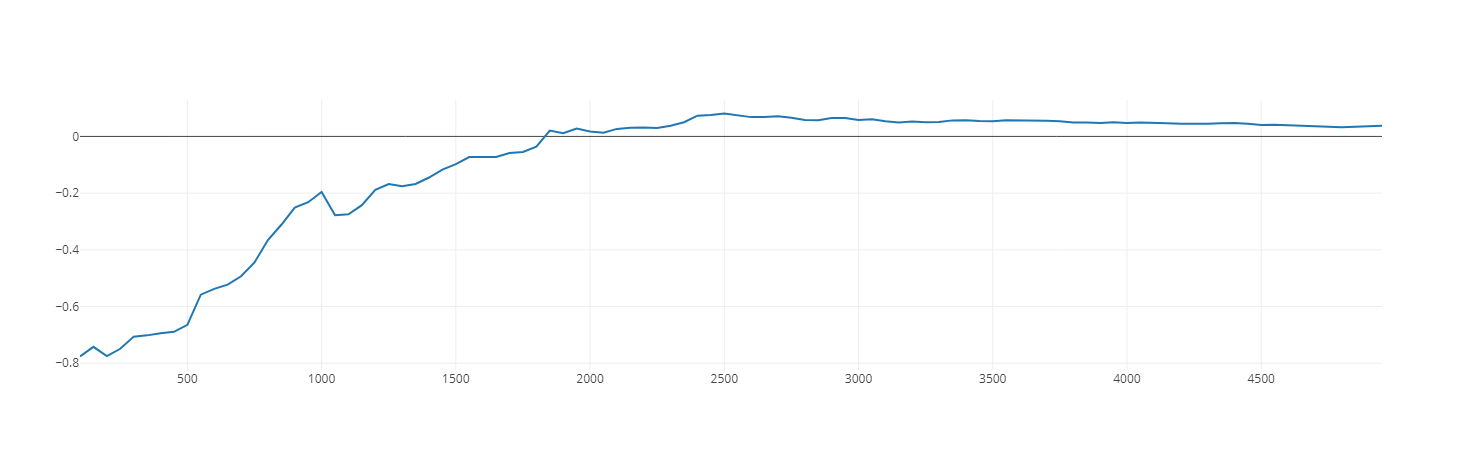

In [275]:
neigh_r_scatter_trace = go.Scatter(x=list(radius_range), y = scores)
py.iplot([neigh_r_scatter_trace])

That doesn't look great, but let's see if we can make a useful map out of it...

In [276]:
traffic_neigh = traffic_neigh = RadiusNeighborsRegressor(radius = 2500/111111)
traffic_neigh.fit(traffic_X, traffic_y)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, p=2,
             radius=0.0225000225000225, weights='uniform')

In [277]:
traffic_heatmap_res = 50 # Number of samples in each axis
traffic_heatmap_lat = []
traffic_heatmap_long = []
traffic_heatmap_Z = []
for lat in np.linspace(50.842, 51.185, traffic_heatmap_res):
    for long in np.linspace(-114.276, -113.912, traffic_heatmap_res):
        traffic_heatmap_lat.append(lat)
        traffic_heatmap_long.append(long)
        traffic_heatmap_Z.append(traffic_neigh.predict([[lat, long]])[0]) # TODO bulk predict

In [345]:
map_traffic = folium.Map(location=[51.0486, -114.0708], zoom_start=11)
for i in range(0, len(traffic_heatmap_Z)):
    folium.Circle(
        location = [traffic_heatmap_lat[i], traffic_heatmap_long[i]],
        radius = traffic_heatmap_Z[i]/200,
        fill_color = 'blue',
        popup = str(traffic_heatmap_Z[i])
    ).add_to(map_traffic)
embed_map(map_traffic, 'traffic')

It's actually pretty good for what we need! There are some flaws (downtown is underestimated due to being many small roads, foot traffic and public transit are not accounted for), but this is a decent heatmap of where people are driving. Let's compare it to restaurants:

In [282]:
map_traffic = folium.Map(location=[51.0486, -114.0708], zoom_start=11)
for i in range(0, len(traffic_heatmap_Z)):
    folium.Circle(
        location = [traffic_heatmap_lat[i], traffic_heatmap_long[i]],
        radius = traffic_heatmap_Z[i]/200,
        fill_color = 'blue',
        popup = str(traffic_heatmap_Z[i])
    ).add_to(map_traffic)
embed_map(map_traffic, 'traffic')
for index, row in venues_df_filtered.iterrows():
    folium.Marker([row['Lat'], row['Long']],
        popup=row['Venue Name']
    ).add_to(map_traffic)
embed_map(map_traffic, 'traffic')

Now we can add our traffic data to the community df:

In [331]:
traffic = traffic_neigh.predict(breakfast_census[['latitude', 'longitude']].values)
breakfast_census['Traffic'] = traffic
breakfast_census.head()

,CLASS,CLASS_CODE,COMM_CODE,COMM_STRUCTURE,DWELL_CNT,EMPLYD_CNT,MF_0_4,MF_15_19,MF_20_24,MF_25_34,...,MF_55_64,MF_5_14,MF_65_74,MF_75,NAME,RES_CNT,latitude,longitude,Breakfast,Traffic
0,Industrial,2,MNI,EMPLOYMENT,3,0,0,0,0,0,...,0,0,0,0,MANCHESTER INDUSTRIAL,0,51.013263,-114.057269,2,24928.571429
1,Industrial,2,EFV,EMPLOYMENT,1,0,0,0,1,4,...,2,0,0,0,EAST FAIRVIEW INDUSTRIAL,15,50.984817,-114.037243,1,41942.857143
2,Industrial,2,FHI,EMPLOYMENT,1,0,0,29,36,62,...,20,0,12,0,FOOTHILLS,304,50.994166,-113.981982,2,16555.555556
3,Industrial,2,SHI,EMPLOYMENT,150,138,15,9,7,30,...,65,9,37,23,SHEPARD INDUSTRIAL,273,50.961480,-113.992775,1,20636.363636
4,Industrial,2,ST4,EMPLOYMENT,4,0,0,0,0,0,...,0,0,0,0,STONEY 4,0,51.176204,-114.002762,1,60000.000000


In [332]:
breakfast_census.corr()['Breakfast']

CLASS_CODE   -0.063346
DWELL_CNT     0.173055
EMPLYD_CNT    0.098043
MF_0_4        0.085310
MF_15_19     -0.049750
MF_20_24      0.097279
MF_25_34      0.223765
MF_35_44      0.122782
MF_45_54     -0.018560
MF_55_64     -0.055308
MF_5_14      -0.016803
MF_65_74     -0.020448
MF_75         0.057342
RES_CNT       0.075812
latitude     -0.038529
longitude     0.069787
Breakfast     1.000000
Traffic      -0.189173
Name: Breakfast, dtype: float64

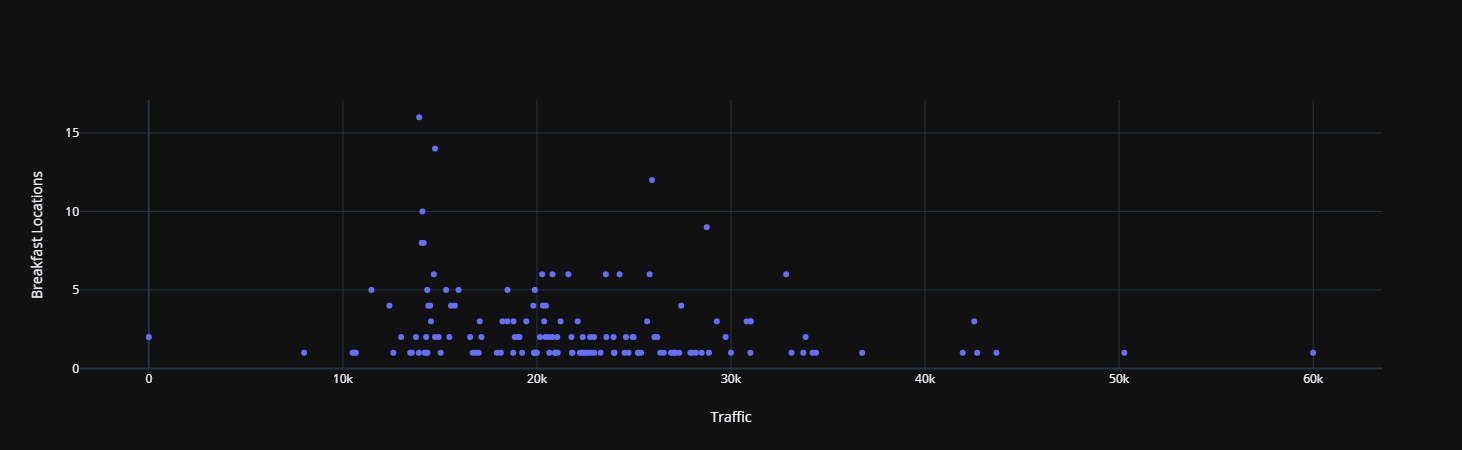

In [333]:
breakfast_traffic_trace = go.Scatter(x = breakfast_census['Traffic'], y = breakfast_census['Breakfast'], name = 'Traffic', mode='markers')
breakfast_traffic_layout = go.Layout(template='plotly_dark', xaxis={'title':'Traffic'}, yaxis={'title':'Breakfast Locations'})
py.plot({'data': [breakfast_traffic_trace], 'layout': breakfast_traffic_layout}, filename = 'breakfast_traffic_skl.html')
py.iplot({'data': [breakfast_traffic_trace], 'layout': breakfast_traffic_layout})

Alright, maybe it wasn't good enough after all. What if, instead of using an average of the roads, we used a sum? SKLearn doesn't support this, but we can perform the same logic easily enough ourselves...

In [334]:
def sum_of_radius(long, lat, radius):
    total = 0
    for index, row in traffic_data.iterrows(): # There MUST be a better way to do this
        if math.sqrt((row['Latitude']-lat)**2 + (row['Longitude']-long)**2) < radius:
            total += row['VOLUME']
    return total

sum_of_radius(51.043, -114.074, 2500/111111)

3696800

In [335]:
traffic = []
for i in range(0, breakfast_census.shape[0]):
    traffic.append(sum_of_radius(breakfast_census.at[i, 'latitude'], breakfast_census.at[i, 'longitude'], 2500/111111))
traffic

[1047000,
 1468000,
 298000,
 454000,
 180000,
 929000,
 325000,
 1066000,
 419000,
 324000,
 1383000,
 588000,
 1150000,
 389000,
 1169000,
 533000,
 1109000,
 984000,
 62000,
 1210000,
 955000,
 1113000,
 1360000,
 314000,
 556000,
 488000,
 200300,
 520000,
 884000,
 383000,
 1263000,
 1202000,
 639000,
 1254000,
 448000,
 809000,
 466200,
 837000,
 109000,
 186000,
 2983800,
 733000,
 997000,
 3802800,
 42000,
 895000,
 1270000,
 240000,
 749000,
 213100,
 227000,
 592000,
 269000,
 2180000,
 195000,
 234000,
 752000,
 618000,
 2817000,
 921000,
 3359000,
 762000,
 1710000,
 495000,
 3417000,
 1092000,
 3686800,
 645000,
 470000,
 137300,
 2010800,
 895000,
 177000,
 1085000,
 592000,
 122000,
 63000,
 2636000,
 1083000,
 369000,
 523000,
 1548800,
 930000,
 754000,
 878000,
 482000,
 784000,
 2701800,
 3837800,
 2692000,
 3030800,
 757000,
 880000,
 862000,
 278000,
 1048000,
 1083000,
 731000,
 3130800,
 459000,
 463000,
 683000,
 1460000,
 128000,
 752000,
 2142000,
 327000,
 46

In [336]:
breakfast_census['Traffic'] = traffic

In [337]:
breakfast_census.corr()['Breakfast']

CLASS_CODE   -0.063346
DWELL_CNT     0.173055
EMPLYD_CNT    0.098043
MF_0_4        0.085310
MF_15_19     -0.049750
MF_20_24      0.097279
MF_25_34      0.223765
MF_35_44      0.122782
MF_45_54     -0.018560
MF_55_64     -0.055308
MF_5_14      -0.016803
MF_65_74     -0.020448
MF_75         0.057342
RES_CNT       0.075812
latitude     -0.038529
longitude     0.069787
Breakfast     1.000000
Traffic       0.492381
Name: Breakfast, dtype: float64

Aha! 0.492 isn't bad. Let's plot our new traffic metric against our target: 

/usr/local/lib/python3.5/dist-packages/plotly/offline/offline.py:635: UserWarning:

Your filename `breakfast_traffic_sum` didn't end with .html. Adding .html to the end of your file.



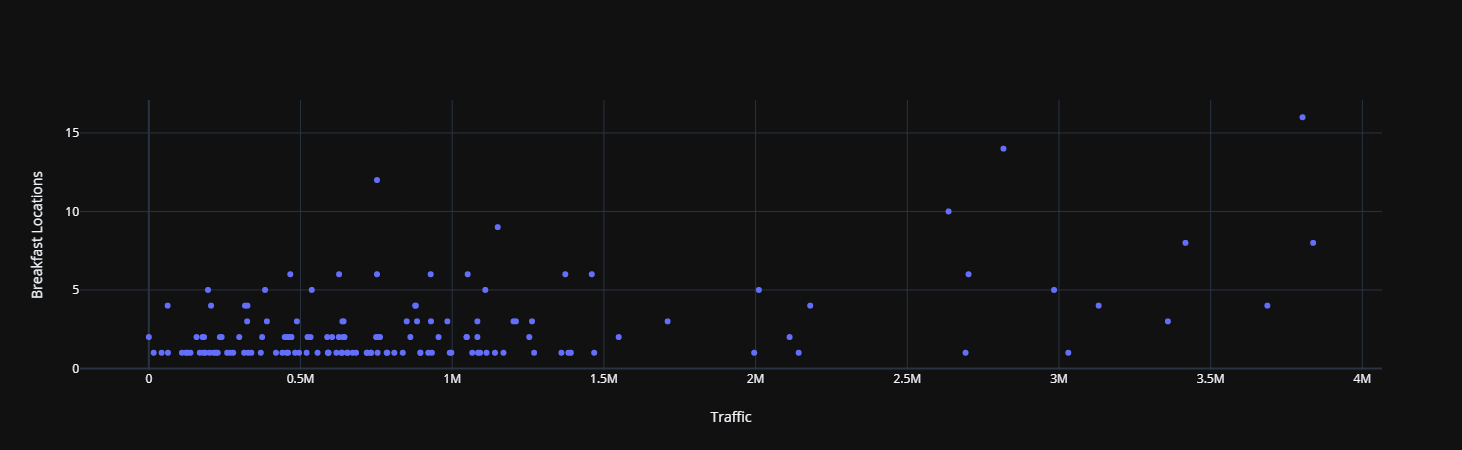

In [341]:
breakfast_traffic_trace = go.Scatter(x = breakfast_census['Traffic'], y = breakfast_census['Breakfast'], name = 'Traffic', mode='markers')
breakfast_traffic_layout = go.Layout(template='plotly_dark', xaxis={'title':'Traffic'}, yaxis={'title':'Breakfast Locations'})
py.plot({'data': [breakfast_traffic_trace], 'layout': breakfast_traffic_layout}, filename = 'breakfast_traffic_sum.html')
py.iplot({'data': [breakfast_traffic_trace], 'layout': breakfast_traffic_layout})

This actually looks like something that could be modeled. Our precision won't be great, of course, but that's fine. The whole point of this is to find which communities have more or less restaurants than the norm for that traffic level. 

In [342]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [343]:
traffic_poly = PolynomialFeatures(degree=2)
traffic_poly_X = traffic_poly.fit_transform(breakfast_census['Traffic'].values.reshape(-1, 1))
traffic_lin = linear_model.LinearRegression()
traffic_lin.fit(traffic_poly_X, breakfast_census['Breakfast'])

traffic_range = np.arange(0.0, 4000000.0, 100000.0)
traffic_poly_yhat = traffic_lin.intercept_ + traffic_lin.coef_[1]*traffic_range+ traffic_lin.coef_[2]*np.power(traffic_range, 2)

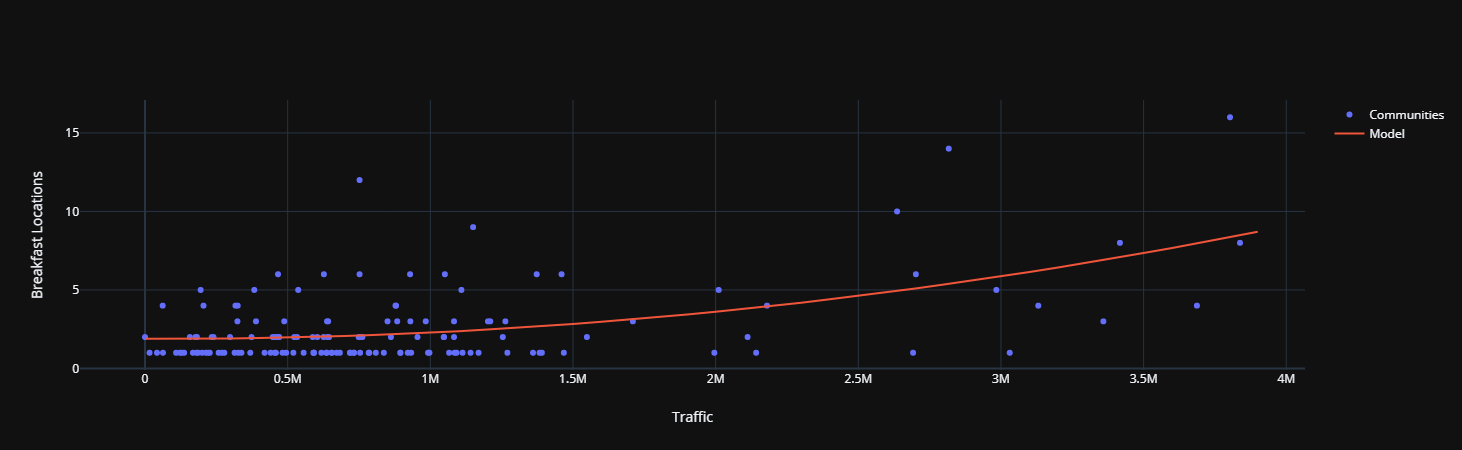

In [344]:
breakfast_traffic_trace = go.Scatter(
    x = breakfast_census['Traffic'], 
    y = breakfast_census['Breakfast'], 
    name = 'Communities',
    mode='markers',
    text = breakfast_census['NAME']
)
breakfast_traffic_poly_trace = go.Scatter(x = traffic_range, y = traffic_poly_yhat, name = 'Model', mode='lines')
breakfast_traffic_layout = go.Layout(template='plotly_dark', xaxis={'title':'Traffic'}, yaxis={'title':'Breakfast Locations'})
py.plot({'data': [breakfast_traffic_trace, breakfast_traffic_poly_trace], 'layout': breakfast_traffic_layout}, filename = 'poly_regress.html')
py.iplot({'data': [breakfast_traffic_trace, breakfast_traffic_poly_trace], 'layout': breakfast_traffic_layout})